<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Sandun-Karunatilleke/ARIMA_and_SARIMA_for_MAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

### Mounting the Drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')
# '/content/drive/MyDrive/Datasets/preprocessed_data_new.xlsx'
# Load preprocessed data from Excel file
# file_path = '/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data_new.xlsx'
file_path = '/content/drive/MyDrive/Datasets/preprocessed_data_new.xlsx'
data = pd.read_excel(file_path)
data


Mounted at /content/drive


,Date,Shift,Code,Department,Absenteeism Type,Status,Leave Type,Absent/Present,Reason,Joined Date,...,LeaveMonth,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,LeaveYear,NumOfLeaveDays,TookLeaveNextMonth,LeavesNextMonth,TargetCategory
0,2021-12-01,Shift A,AA369,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2015-09-11,...,12,11,1,0,0,2021,4,0,0,A
1,2021-12-01,Shift A,AA362,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2018-11-14,...,12,11,1,0,0,2021,4,1,24,B
2,2021-12-01,Shift A,AA359,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2019-10-09,...,12,11,1,0,0,2021,4,1,16,B
3,2021-12-01,Shift A,AA541,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2020-10-02,...,12,11,1,0,0,2021,4,1,2,A
4,2021-12-01,Shift A,AA398,Team - MAT 3A - BD,Informed,Notified,1,MAT,Maternity,2008-02-29,...,12,11,1,0,0,2021,4,1,1,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40661,2023-12-22,Shift A,AA2212,Sewing Team - 145A - II - BD,Uninformed,Notified,1,Absent,Health Related,2018-06-12,...,12,9,1,1,0,2023,1,0,0,A
40662,2023-12-22,Shift A,AA723,Sewing Team - 109A - I - BD,Informed,Notified,1,Absent,Personal Reason,2017-11-15,...,12,15,1,0,0,2023,1,0,0,A
40663,2023-12-22,Shift A,AA1280,Sewing Team - 152A - I - BD,Informed,Notified,1,Absent,Personal Reason,2018-12-19,...,12,15,1,0,0,2023,1,0,0,A
40664,2023-12-22,Shift A,AA1964,Sewing Team - 135A - I - BD,Informed,Notified,1,Absent,Personal Reason,2021-07-02,...,12,15,1,0,0,2023,1,0,0,A


### EDA

In [3]:
# Define a mapping of sub-departments to main departments
sub_dept_to_main_dept = {
    'MAT': [sub_dept for sub_dept in data['Department'] if sub_dept.startswith('Team - MAT')]
}



# Map each sub-department to its main department
main_dept_for_sub_dept = {}
for main_dept, sub_depts in sub_dept_to_main_dept.items():
    for sub_dept in sub_depts:
        main_dept_for_sub_dept[sub_dept] = main_dept

# Add a new column indicating the main department for each row
data['MainDepartment'] = data['Department'].map(main_dept_for_sub_dept)


In [4]:
# Summarize total absence by main department
total_absence_by_main_dept = data.groupby(['LeaveYear','LeaveMonth','MainDepartment']).size().reset_index(name='totalAbsence')

#total_absence_by_main_dept.drop(17, inplace=True)
total_absence_by_main_dept

,LeaveYear,LeaveMonth,MainDepartment,totalAbsence
0,2021,12,MAT,203
1,2022,1,MAT,127
2,2022,2,MAT,158
3,2022,3,MAT,235
4,2022,4,MAT,107
5,2022,5,MAT,175
6,2022,6,MAT,139
7,2022,7,MAT,147
8,2022,8,MAT,100
9,2022,9,MAT,79


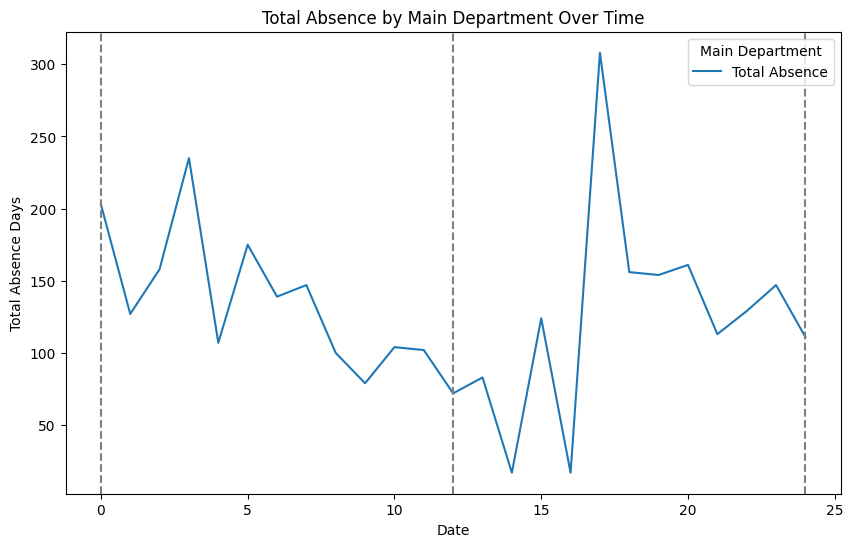

In [5]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(total_absence_by_main_dept['totalAbsence'], label='Total Absence')

# Adding dotted lines at 5-day intervals
for i in range(0, len(total_absence_by_main_dept),12):
    plt.axvline(x=i, color='gray', linestyle='--')

plt.title('Total Absence by Main Department Over Time')
plt.xlabel('Date')
plt.ylabel('Total Absence Days')
plt.legend(title='Main Department')
plt.show()


### ADF Test

In [6]:
# Check for stationarity
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

### Splitting Data

In [7]:
# Train-test split
train_size = int(len(total_absence_by_main_dept['totalAbsence']) * 0.8)
train, test = total_absence_by_main_dept['totalAbsence'].iloc[:train_size], total_absence_by_main_dept['totalAbsence'].iloc[train_size:]

### ARIMA Model

### Evaluating Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE :  2784.0886307701076
RSME :  52.764463711574926


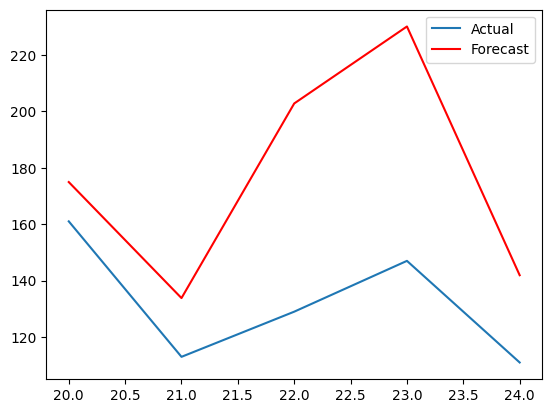

In [8]:
# Fit ARIMA model for each main department
model = ARIMA(train, order=(1,1,10))
model_fit = model.fit()

#print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test))
#print(forecast)

mse = mean_squared_error(test, forecast)
print("MSE : ", mse)

rsme = np.sqrt(mse)
print("RSME : ", rsme)

plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.show()



## ADF Test

In [9]:
# Check for stationarity
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


## Splitting Data

In [10]:
# Train-test split
train_size = int(len(total_absence_by_main_dept['totalAbsence']) * 0.9)
train, test = total_absence_by_main_dept['totalAbsence'].iloc[:train_size], total_absence_by_main_dept['totalAbsence'].iloc[train_size:]


## EDA

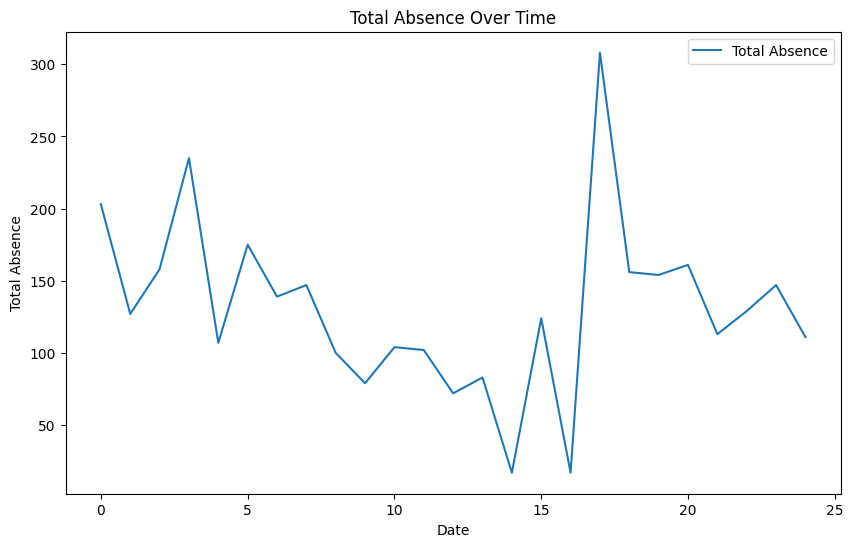

Descriptive Statistics:
count     25.000000
mean     130.720000
std       61.577539
min       17.000000
25%      102.000000
50%      127.000000
75%      156.000000
max      308.000000
Name: totalAbsence, dtype: float64


In [11]:
# EDA
# Data Visualization
plt.figure(figsize=(10, 6))
plt.plot(total_absence_by_main_dept['totalAbsence'], label='Total Absence')
plt.title('Total Absence Over Time')
plt.xlabel('Date')
plt.ylabel('Total Absence')
plt.legend()
plt.show()

# Descriptive Statistics
print("Descriptive Statistics:")
print(total_absence_by_main_dept['totalAbsence'].describe())

## SARIMA Model


In [12]:
# SARIMA modeling (continued from original code)
order = (0, 1, 0)  # Non-seasonal parameters
seasonal_order = (1, 0, 1, 10)  # Seasonal parameters, here assuming a yearly seasonal pattern

# Fit SARIMA model
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.forecast(steps=len(test))
print(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


22    113.233768
23    137.052803
24     84.491515
Name: predicted_mean, dtype: float64


In [13]:
import pickle

# Save the model to a file
with open('mat_sarima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)


### Evaluating the *Model*

MSE: 350.07353085652767
RMSE: 18.710252025467955


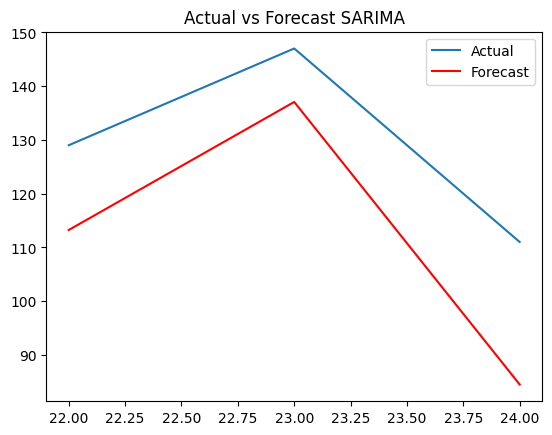

                                      SARIMAX Results                                       
Dep. Variable:                         totalAbsence   No. Observations:                   22
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 10)   Log Likelihood                -123.912
Date:                              Sat, 02 Mar 2024   AIC                            253.824
Time:                                      11:17:52   BIC                            256.957
Sample:                                           0   HQIC                           254.504
                                               - 22                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L10       0.9979      0.047     21.301      0.000       0.906       1.090
ma.S.L10      -0.95

In [14]:
# Calculate MSE and RMSE
mse = mean_squared_error(test, forecast)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Visualize actual vs forecast
plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.title('Actual vs Forecast SARIMA')
plt.show()

print(model_fit.summary())